In [1]:
#Importing necessary libraries 
import keras
import numpy as np
import pandas as pd
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

/home/sachin_sharma/.conda/envs/tf18/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)
    

<keras.engine.input_layer.InputLayer object at 0x7fbe32bedcf8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbe31067710> True
<keras.layers.convolutional.Conv2D object at 0x7fbe310674e0> True
<keras.layers.normalization.BatchNormalization object at 0x7fbe31067be0> True
<keras.layers.core.Activation object at 0x7fbe31067a20> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7fbe30734860> True
<keras.layers.pooling.MaxPooling2D object at 0x7fbe306ec8d0> True
<keras.layers.convolutional.Conv2D object at 0x7fbe30fceba8> True
<keras.layers.normalization.BatchNormalization object at 0x7fbe30688630> True
<keras.layers.core.Activation object at 0x7fbe30688f98> True
<keras.layers.convolutional.Conv2D object at 0x7fbe30629e48> True
<keras.layers.normalization.BatchNormalization object at 0x7fbe305ee898> True
<keras.layers.core.Activation object at 0x7fbe30605390> True
<keras.layers.convolutional.Conv2D object at 0x7fbe3073c6d8> True
<keras.layers.convolutional.Conv2D obj

In [4]:
# Adding classifier on top of Convolutional base
# create the model
model = models.Sequential()

In [5]:
# Add the resnet50 convolutional model
model.add(resnet_model)

In [6]:
# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

In [7]:
# Showing summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 9225      
Total params: 31,986,569
Trainable params: 31,933,449
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(  
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True)

In [9]:
# Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# path to your experimental data
os.chdir('/home/sachin_sharma/Desktop/jpg_data')

In [11]:
# This will create 80:20 split of training and test set 
training_set = train_datagen.flow_from_directory(
        'TrainingSet',
         target_size=(64,64),
         batch_size=32,
         class_mode='categorical')

Found 20140 images belonging to 9 classes.


In [12]:
# This will create the Test set
test_set = test_datagen.flow_from_directory(
        'TestSet',
        target_size=(64,64),
        batch_size=32,
        class_mode='categorical', 
        shuffle=False)


Found 5660 images belonging to 9 classes.


In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [14]:
# Train the model
history = model.fit_generator(
          training_set, 
          steps_per_epoch=(training_set.samples/32),
          epochs=30,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))

Epoch 1/30
630/629 [==============================] - 48s 76ms/step - loss: 1.6508 - acc: 0.5024 - val_loss: 1.1164 - val_acc: 0.6512
Epoch 2/30
630/629 [==============================] - 39s 61ms/step - loss: 0.9225 - acc: 0.6775 - val_loss: 0.7530 - val_acc: 0.7210
Epoch 3/30
630/629 [==============================] - 39s 62ms/step - loss: 0.7574 - acc: 0.7322 - val_loss: 0.7023 - val_acc: 0.7470
Epoch 4/30
630/629 [==============================] - 40s 63ms/step - loss: 0.6737 - acc: 0.7609 - val_loss: 0.8904 - val_acc: 0.7011
Epoch 5/30
630/629 [==============================] - 39s 62ms/step - loss: 0.6358 - acc: 0.7829 - val_loss: 0.6465 - val_acc: 0.7678
Epoch 6/30
630/629 [==============================] - 39s 62ms/step - loss: 0.5801 - acc: 0.7992 - val_loss: 0.5384 - val_acc: 0.8041
Epoch 7/30
630/629 [==============================] - 39s 62ms/step - loss: 0.5608 - acc: 0.8115 - val_loss: 0.4764 - val_acc: 0.8332
Epoch 8/30
630/629 [==============================] - 41s 65ms

In [19]:
model.save('exp_a_1.1.h5')


In [15]:
# Visualizing the mapping between labels
training_set.class_indices

{'AnnualCrop': 0,
 'Buildup': 1,
 'Forest': 2,
 'HerbaceousVegetation': 3,
 'Highway': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'River': 7,
 'SeaLake': 8}

In [16]:
# Confusion Matrix 
Y_pred = model.predict_generator(test_set, test_set.samples//32 +1 )
y_pred = np.argmax(Y_pred, axis=1) # predictions
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
#print(cm)
# visualizing results in table
def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

df = cm2df(cm, ["AnnualCrop", "Buildup", "Forest", "HerbaceousVegetation", "Highway", "Pasture", "PermanentCrop", "River", "SeaLake"])
print(df)

Confusion Matrix
                      AnnualCrop  Buildup  Forest  HerbaceousVegetation  \
AnnualCrop                   387        0       3                    45   
Buildup                        0      848       0                     3   
Forest                         0        0     504                    76   
HerbaceousVegetation           0        6       0                   557   
Highway                        2       31       0                    26   
Pasture                        6        7      10                    41   
PermanentCrop                  2        5       0                    67   
River                          8        7       3                    31   
SeaLake                       11        0      73                    65   

                      Highway  Pasture  PermanentCrop  River  SeaLake  
AnnualCrop                 13       10            121     21        0  
Buildup                     8        0              1      0        0  
Forest          

In [17]:
# Classification report
print('Classification Report')
target_names = ['AnnualCrop','Buildup','Forest', 'HerbaceousVegetation', 'Highway', 'Pasture', 'PermanentCrop', 'River', 'SeaLake']
classificn_report = classification_report(test_set.classes, y_pred, target_names=target_names)
print(classificn_report)

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.65      0.76       600
             Buildup       0.94      0.99      0.96       860
              Forest       0.85      0.84      0.84       600
HerbaceousVegetation       0.61      0.93      0.74       600
             Highway       0.86      0.83      0.85       600
             Pasture       0.90      0.69      0.78       600
       PermanentCrop       0.60      0.85      0.70       600
               River       0.90      0.78      0.84       600
             SeaLake       1.00      0.70      0.82       600

           micro avg       0.81      0.81      0.81      5660
           macro avg       0.84      0.81      0.81      5660
        weighted avg       0.85      0.81      0.82      5660



dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


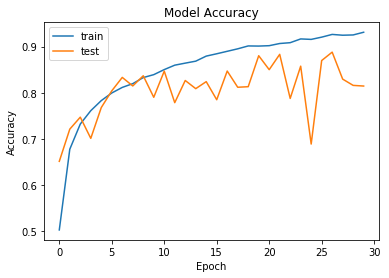

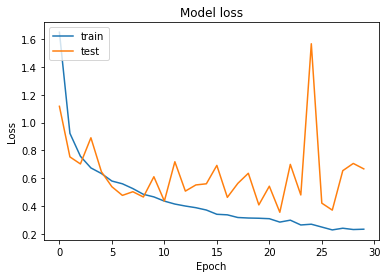

In [18]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
